In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import VOCSegmentation
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
class MakeClass(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.num_class = num_class

    def forward(self, x):
        x[x == 255] = 21
        return F.one_hot(x.to(torch.int64), self.num_class).permute(0, 3, 1, 2)[0].float()

transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.PILToTensor(), 
        MakeClass(22)
    ]
)

train_ds = VOCSegmentation(
    root = "~/data", image_set = "train", download = True, year = "2009",
    transform = transform, 
    target_transform = target_transform
)

valid_ds = VOCSegmentation(
    root = "~/data", image_set = "trainval", download = True, year = "2009",
    transform = transform, 
    target_transform = target_transform    
)

test_ds = VOCSegmentation(
    root = "~/data", image_set = "val", download = True, year = "2009",
    transform = transform, 
    target_transform = target_transform
)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Samples: {}".format(len(train_ds)))
print("#Validation Samples: {}".format(len(valid_ds)))
print("#Testing Samples: {}".format(len(test_ds)))
print("#Training Batch: {}".format(len(train_dl)))
print("#Validation Batch: {}".format(len(valid_dl)))
print("#Testing Batch: {}".format(len(test_dl)))

Using downloaded and verified file: /home/khoidh/data/VOCtrainval_11-May-2009.tar
Extracting /home/khoidh/data/VOCtrainval_11-May-2009.tar to /home/khoidh/data
Using downloaded and verified file: /home/khoidh/data/VOCtrainval_11-May-2009.tar
Extracting /home/khoidh/data/VOCtrainval_11-May-2009.tar to /home/khoidh/data
Using downloaded and verified file: /home/khoidh/data/VOCtrainval_11-May-2009.tar
Extracting /home/khoidh/data/VOCtrainval_11-May-2009.tar to /home/khoidh/data
#Training Samples: 749
#Validation Samples: 1499
#Testing Samples: 750
#Training Batch: 24
#Validation Batch: 47
#Testing Batch: 24


Total #Class: 22
data shape: torch.Size([3, 256, 256])
mask shape: torch.Size([22, 256, 256])
Number classes: 22
Classes: tensor([ 0, 15, 21])


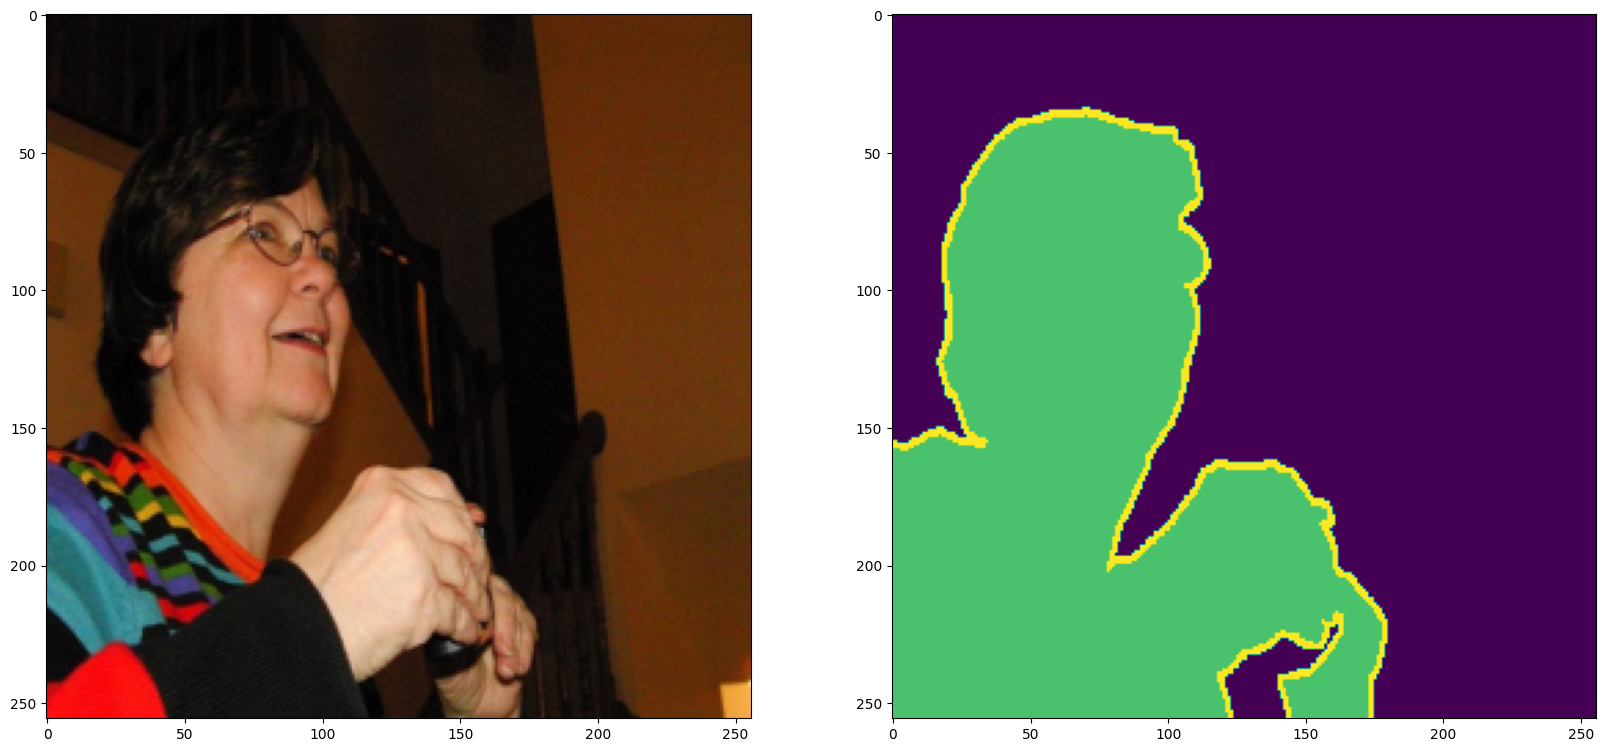

In [3]:
sample_data, sample_mask = train_ds[200]
total_num_class = 22

print(f"Total #Class: {total_num_class}")
print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")
num_class = sample_mask.shape[0]
print(f"Number classes: {num_class}")
print(f"Classes: {torch.unique(torch.argmax(sample_mask, dim = 0))}")

f, axarr = plt.subplots(1, 2, figsize=(20, 15))
axarr[0].imshow(sample_data.permute(1, -1, 0).numpy())
axarr[1].imshow(torch.argmax(sample_mask, dim = 0).unsqueeze(0).permute(1, -1, 0).numpy())

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [5]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [6]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [7]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [8]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64)) #64, 128
        self.down2 = (Down(64, 128)) #128, 256
        self.down3 = (Down(128, 256)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(256, 512 // factor)) #512, 1024
        self.up1 = (Up(512, 256 // factor, bilinear)) #1024, 512
        self.up2 = (Up(256, 128 // factor, bilinear)) #512, 256
        self.up3 = (Up(128, 64 // factor, bilinear)) #256, 128
        self.up4 = (Up(64, 32, bilinear)) #128, 64
        self.outc = (OutConv(32, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [9]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = UNet(3, total_num_class, True).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

loss_fn = nn.CrossEntropyLoss()

In [11]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)
        train_rec_loss = loss_fn(train_gen_mask, train_mask)
        train_dice_loss = dice_loss(
            F.softmax(train_gen_mask, dim=1).float(),
            train_mask.float(),
            multiclass=True
        )
        train_loss = train_rec_loss + train_dice_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.cpu().item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, valid_mask in tqdm(valid_dl):
            valid_img = valid_img.to(device)
            valid_mask = valid_mask.to(device)
            
            valid_gen_mask = model(valid_img)
            valid_loss = loss_fn(valid_gen_mask, valid_mask)
            valid_dice_loss = dice_loss(
                F.softmax(valid_gen_mask, dim=1).float(),
                valid_mask.float(),
                multiclass=True
            )
            valid_loss = train_rec_loss + train_dice_loss

            va_total_loss += valid_loss.cpu().item()
            
    mean_train_loss = tr_total_loss/len(train_dl)
    mean_valid_loss = va_total_loss/len(test_dl)

    if mean_valid_loss <= old_loss:
        old_loss = mean_valid_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss} - ValidLoss: {mean_valid_loss}")
model.load_state_dict(best_dct)

100%|███████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.83it/s]


Epoch: 0 - TrainLoss: 3.716563254594803 - ValidLoss: 6.576413512229919


100%|███████████████████████████████████████████████████████████████████████| 47/47 [00:10<00:00,  4.46it/s]


Epoch: 1 - TrainLoss: 3.17948446671168 - ValidLoss: 5.72774064540863


100%|███████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.74it/s]


Epoch: 2 - TrainLoss: 2.7440408070882163 - ValidLoss: 4.827252745628357


100%|███████████████████████████████████████████████████████████████████████| 47/47 [00:10<00:00,  4.34it/s]


Epoch: 3 - TrainLoss: 2.4191499948501587 - ValidLoss: 4.208128561576207


100%|███████████████████████████████████████████████████████████████████████| 47/47 [00:10<00:00,  4.54it/s]


Epoch: 4 - TrainLoss: 2.112754300236702 - ValidLoss: 3.7154454588890076


100%|███████████████████████████████████████████████████████████████████████| 47/47 [00:11<00:00,  4.03it/s]


Epoch: 5 - TrainLoss: 1.8756500333547592 - ValidLoss: 3.1301259895165763


100%|███████████████████████████████████████████████████████████████████████| 47/47 [00:10<00:00,  4.54it/s]


Epoch: 6 - TrainLoss: 1.7404724558194478 - ValidLoss: 3.5377781093120575


100%|███████████████████████████████████████████████████████████████████████| 47/47 [00:10<00:00,  4.44it/s]


Epoch: 7 - TrainLoss: 1.624923641482989 - ValidLoss: 2.4387803077697754


100%|███████████████████████████████████████████████████████████████████████| 47/47 [00:11<00:00,  4.17it/s]


Epoch: 8 - TrainLoss: 1.5903965880473454 - ValidLoss: 3.246612697839737


100%|███████████████████████████████████████████████████████████████████████| 47/47 [00:10<00:00,  4.36it/s]


Epoch: 9 - TrainLoss: 1.5677879999081294 - ValidLoss: 2.717416375875473


100%|███████████████████████████████████████████████████████████████████████| 47/47 [00:10<00:00,  4.33it/s]


Epoch: 10 - TrainLoss: 1.5524942974249523 - ValidLoss: 2.7604377567768097


100%|███████████████████████████████████████████████████████████████████████| 47/47 [00:10<00:00,  4.50it/s]


Epoch: 11 - TrainLoss: 1.5381959130366643 - ValidLoss: 3.1532267183065414


100%|███████████████████████████████████████████████████████████████████████| 47/47 [00:10<00:00,  4.50it/s]


Epoch: 12 - TrainLoss: 1.5320972055196762 - ValidLoss: 3.321517954270045


100%|███████████████████████████████████████████████████████████████████████| 47/47 [00:10<00:00,  4.63it/s]


Epoch: 13 - TrainLoss: 1.5250046998262405 - ValidLoss: 3.267620767156283


100%|███████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.81it/s]


Epoch: 14 - TrainLoss: 1.5088673532009125 - ValidLoss: 2.4787700871626535


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.07it/s]


Epoch: 15 - TrainLoss: 1.4806053936481476 - ValidLoss: 2.114765932162603


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.83it/s]


Epoch: 16 - TrainLoss: 1.4825573712587357 - ValidLoss: 3.3533247907956443


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.13it/s]


Epoch: 17 - TrainLoss: 1.4855663975079854 - ValidLoss: 2.8351359417041144


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.89it/s]


Epoch: 18 - TrainLoss: 1.471209893623988 - ValidLoss: 2.099234869082769


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.02it/s]


Epoch: 19 - TrainLoss: 1.4590991586446762 - ValidLoss: 3.0414860794941583


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.09it/s]


Epoch: 20 - TrainLoss: 1.4545225501060486 - ValidLoss: 3.2103439023097358


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.99it/s]


Epoch: 21 - TrainLoss: 1.422276606162389 - ValidLoss: 2.4944792737563453


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.13it/s]


Epoch: 22 - TrainLoss: 1.4099579254786174 - ValidLoss: 2.0880425026019416


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.79it/s]


Epoch: 23 - TrainLoss: 1.4006421864032745 - ValidLoss: 2.8585340877374015


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.20it/s]


Epoch: 24 - TrainLoss: 1.395312895377477 - ValidLoss: 3.4741835792859397


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.27it/s]


Epoch: 25 - TrainLoss: 1.371454159418742 - ValidLoss: 2.484623650709788


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.31it/s]


Epoch: 26 - TrainLoss: 1.361180990934372 - ValidLoss: 2.8071943620840707


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.37it/s]


Epoch: 27 - TrainLoss: 1.3421405653158824 - ValidLoss: 2.5152230759461722


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.17it/s]


Epoch: 28 - TrainLoss: 1.3535159081220627 - ValidLoss: 2.7660728096961975


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.01it/s]


Epoch: 29 - TrainLoss: 1.311576212445895 - ValidLoss: 2.160398701826731


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.06it/s]


Epoch: 30 - TrainLoss: 1.2989161958297093 - ValidLoss: 2.4835698505242667


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.22it/s]


Epoch: 31 - TrainLoss: 1.2979825884103775 - ValidLoss: 2.9221641023953757


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.93it/s]


Epoch: 32 - TrainLoss: 1.2761910408735275 - ValidLoss: 2.320807913939158


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.13it/s]


Epoch: 33 - TrainLoss: 1.2773807098468144 - ValidLoss: 3.2223794957002005


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.19it/s]


Epoch: 34 - TrainLoss: 1.2530110826094945 - ValidLoss: 2.426096419493357


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.21it/s]


Epoch: 35 - TrainLoss: 1.2377108211318653 - ValidLoss: 2.137879967689514


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.06it/s]


Epoch: 36 - TrainLoss: 1.208485834300518 - ValidLoss: 2.021093040704727


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.11it/s]


Epoch: 37 - TrainLoss: 1.2008100375533104 - ValidLoss: 2.104893500606219


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.95it/s]


Epoch: 38 - TrainLoss: 1.1663952668507893 - ValidLoss: 2.3723348677158356


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.08it/s]


Epoch: 39 - TrainLoss: 1.1559945046901703 - ValidLoss: 2.357481747865677


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.98it/s]


Epoch: 40 - TrainLoss: 1.1616570179661114 - ValidLoss: 1.896384169658025


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.03it/s]


Epoch: 41 - TrainLoss: 1.1395496999224026 - ValidLoss: 2.30922731757164


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.06it/s]


Epoch: 42 - TrainLoss: 1.1097747658689816 - ValidLoss: 2.107737640539805


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:11<00:00,  4.17it/s]


Epoch: 43 - TrainLoss: 1.0854705969492595 - ValidLoss: 2.0634630918502808


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.23it/s]


Epoch: 44 - TrainLoss: 1.0614494755864143 - ValidLoss: 2.111384153366089


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.05it/s]


Epoch: 45 - TrainLoss: 1.05043076723814 - ValidLoss: 1.982564200957616


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.09it/s]


Epoch: 46 - TrainLoss: 1.0284244219462078 - ValidLoss: 2.125369300444921


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.07it/s]


Epoch: 47 - TrainLoss: 1.0218736877044041 - ValidLoss: 2.00272927681605


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.15it/s]


Epoch: 48 - TrainLoss: 1.0033384015162785 - ValidLoss: 1.5156718889872234


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.40it/s]


Epoch: 49 - TrainLoss: 0.9777441571156184 - ValidLoss: 2.0931688646475473


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.10it/s]


Epoch: 50 - TrainLoss: 0.9637348900238673 - ValidLoss: 2.2107742726802826


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.02it/s]


Epoch: 51 - TrainLoss: 0.9443662390112877 - ValidLoss: 1.9305284395813942


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.93it/s]


Epoch: 52 - TrainLoss: 0.9253237272302309 - ValidLoss: 2.022133767604828


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.11it/s]


Epoch: 53 - TrainLoss: 0.9002815360824267 - ValidLoss: 1.7046239351232846


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.04it/s]


Epoch: 54 - TrainLoss: 0.8906305134296417 - ValidLoss: 2.8546648621559143


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.04it/s]


Epoch: 55 - TrainLoss: 0.8604837134480476 - ValidLoss: 1.3284475008646648


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.18it/s]


Epoch: 56 - TrainLoss: 0.8603966136773428 - ValidLoss: 2.5266099075476327


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.19it/s]


Epoch: 57 - TrainLoss: 0.8346857701738676 - ValidLoss: 1.572758140663306


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.03it/s]


Epoch: 58 - TrainLoss: 0.8165151203672091 - ValidLoss: 1.3706424633661907


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.13it/s]


Epoch: 59 - TrainLoss: 0.8015157083670298 - ValidLoss: 1.7821643923719723


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.06it/s]


Epoch: 60 - TrainLoss: 0.7784234409530958 - ValidLoss: 1.8048004359006882


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.01it/s]


Epoch: 61 - TrainLoss: 0.7401852160692215 - ValidLoss: 1.6316761697332065


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.03it/s]


Epoch: 62 - TrainLoss: 0.7312276487549146 - ValidLoss: 1.2223559220631917


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.01it/s]


Epoch: 63 - TrainLoss: 0.7656049653887749 - ValidLoss: 2.315943717956543


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.15it/s]


Epoch: 64 - TrainLoss: 0.7379424646496773 - ValidLoss: 1.481505090991656


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.95it/s]


Epoch: 65 - TrainLoss: 0.7233355318506559 - ValidLoss: 1.2982800776759784


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.07it/s]


Epoch: 66 - TrainLoss: 0.6905566230416298 - ValidLoss: 1.6161818752686183


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.06it/s]


Epoch: 67 - TrainLoss: 0.7188167174657186 - ValidLoss: 1.7102671588460605


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.06it/s]


Epoch: 68 - TrainLoss: 0.6885558540622393 - ValidLoss: 1.3448894917964935


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.11it/s]


Epoch: 69 - TrainLoss: 0.6862519135077795 - ValidLoss: 2.3645364195108414


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.19it/s]


Epoch: 70 - TrainLoss: 0.6839978794256846 - ValidLoss: 2.1860996137062707


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.99it/s]


Epoch: 71 - TrainLoss: 0.6476335823535919 - ValidLoss: 1.4152629872163136


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.97it/s]


Epoch: 72 - TrainLoss: 0.6381801354388396 - ValidLoss: 1.2432151660323143


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.05it/s]


Epoch: 73 - TrainLoss: 0.6100720390677452 - ValidLoss: 1.3391505529483159


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.03it/s]


Epoch: 74 - TrainLoss: 0.6062210388481617 - ValidLoss: 1.0009864469369252


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.19it/s]


Epoch: 75 - TrainLoss: 0.5996582930286726 - ValidLoss: 1.5813189248243968


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.42it/s]


Epoch: 76 - TrainLoss: 0.5882394847770532 - ValidLoss: 1.5512723128000896


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.42it/s]


Epoch: 77 - TrainLoss: 0.5959456016620001 - ValidLoss: 1.4172753393650055


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.95it/s]


Epoch: 78 - TrainLoss: 0.5730502158403397 - ValidLoss: 1.0620861972371738


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.17it/s]


Epoch: 79 - TrainLoss: 0.5679047691325346 - ValidLoss: 1.1357855598131816


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.17it/s]


Epoch: 80 - TrainLoss: 0.5702872710923353 - ValidLoss: 1.26342378060023


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.19it/s]


Epoch: 81 - TrainLoss: 0.5723267545302709 - ValidLoss: 1.4566708679000537


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.10it/s]


Epoch: 82 - TrainLoss: 0.5581587813794613 - ValidLoss: 1.4840322037537892


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.78it/s]


Epoch: 83 - TrainLoss: 0.541141559680303 - ValidLoss: 1.279561350742976


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.13it/s]


Epoch: 84 - TrainLoss: 0.5547836236655712 - ValidLoss: 2.011671870946884


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.04it/s]


Epoch: 85 - TrainLoss: 0.5308447194596132 - ValidLoss: 0.7840353337426981


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.07it/s]


Epoch: 86 - TrainLoss: 0.5408407375216484 - ValidLoss: 1.3105209916830063


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.10it/s]


Epoch: 87 - TrainLoss: 0.5362865105271339 - ValidLoss: 1.1463679174582164


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.85it/s]


Epoch: 88 - TrainLoss: 0.5317182776828607 - ValidLoss: 1.7270007307330768


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.05it/s]


Epoch: 89 - TrainLoss: 0.5272989645600319 - ValidLoss: 1.2665579840540886


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.05it/s]


Epoch: 90 - TrainLoss: 0.5214640585084757 - ValidLoss: 1.0833524639407794


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.24it/s]


Epoch: 91 - TrainLoss: 0.5196256637573242 - ValidLoss: 1.308073252439499


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.15it/s]


Epoch: 92 - TrainLoss: 0.5137050934135914 - ValidLoss: 1.0519455298781395


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.29it/s]


Epoch: 93 - TrainLoss: 0.5098790526390076 - ValidLoss: 0.9166055681804816


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.03it/s]


Epoch: 94 - TrainLoss: 0.5124091853698095 - ValidLoss: 1.8151743213335674


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.18it/s]


Epoch: 95 - TrainLoss: 0.518376904229323 - ValidLoss: 0.9585253496964773


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  5.21it/s]


Epoch: 96 - TrainLoss: 0.5135891661047935 - ValidLoss: 1.0380786259969075


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.96it/s]


Epoch: 97 - TrainLoss: 0.5183769998451074 - ValidLoss: 1.1068487763404846


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.26it/s]


Epoch: 98 - TrainLoss: 0.5175742407639822 - ValidLoss: 0.9923417369524637


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.33it/s]

Epoch: 99 - TrainLoss: 0.5048733142515024 - ValidLoss: 0.9871075203021368


<All keys matched successfully>

In [12]:
model.eval()
with torch.no_grad():
    ts_total_loss = 0
    for test_img, test_mask in tqdm(test_dl):
        test_img = test_img.to(device)
        test_mask = test_mask.to(device)
        
        test_gen_mask = model(test_img)
        test_rec_loss = loss_fn(test_gen_mask, test_mask)
        test_dice_loss = dice_loss(
            F.softmax(test_gen_mask, dim=1).float(),
            test_mask.float(),
            multiclass=True
        )
        test_loss = test_rec_loss + test_dice_loss

        ts_total_loss += test_loss.cpu().item()
mean_test_loss = ts_total_loss/len(test_dl)
print(f"TestLoss: {mean_test_loss}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:07<00:00,  3.38it/s]

TestLoss: 1.5466930866241455


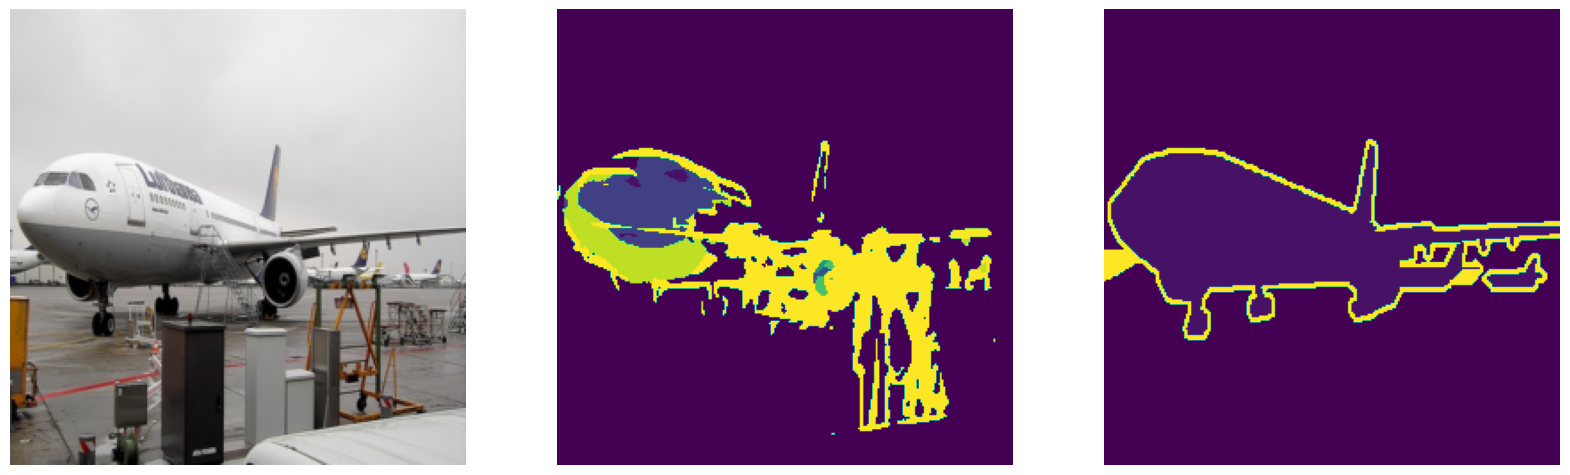

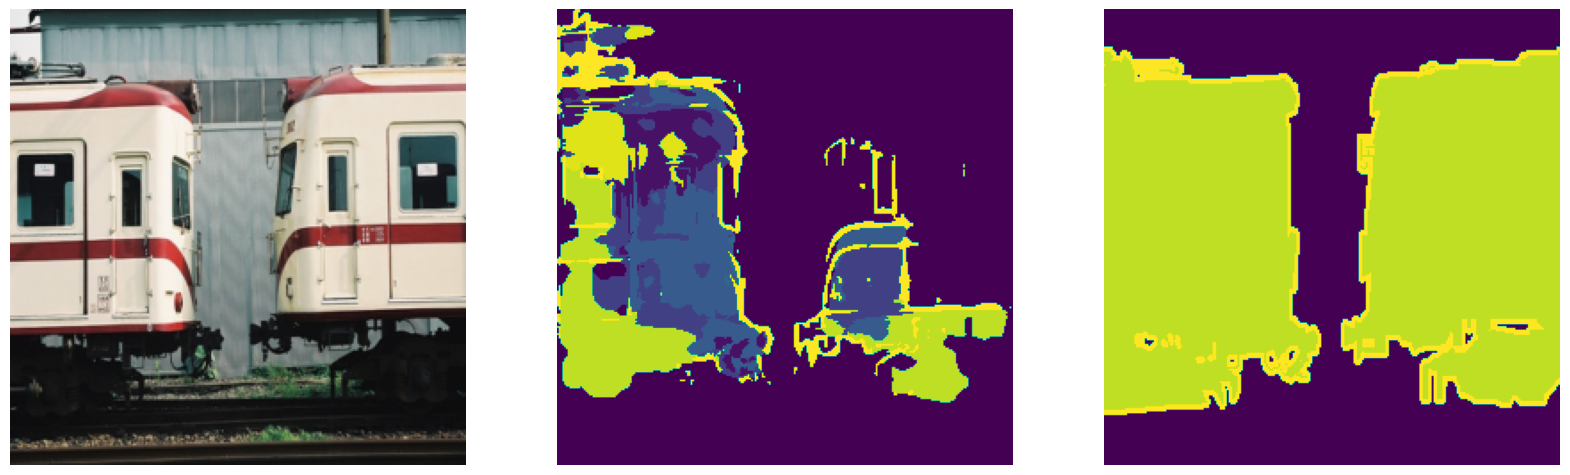

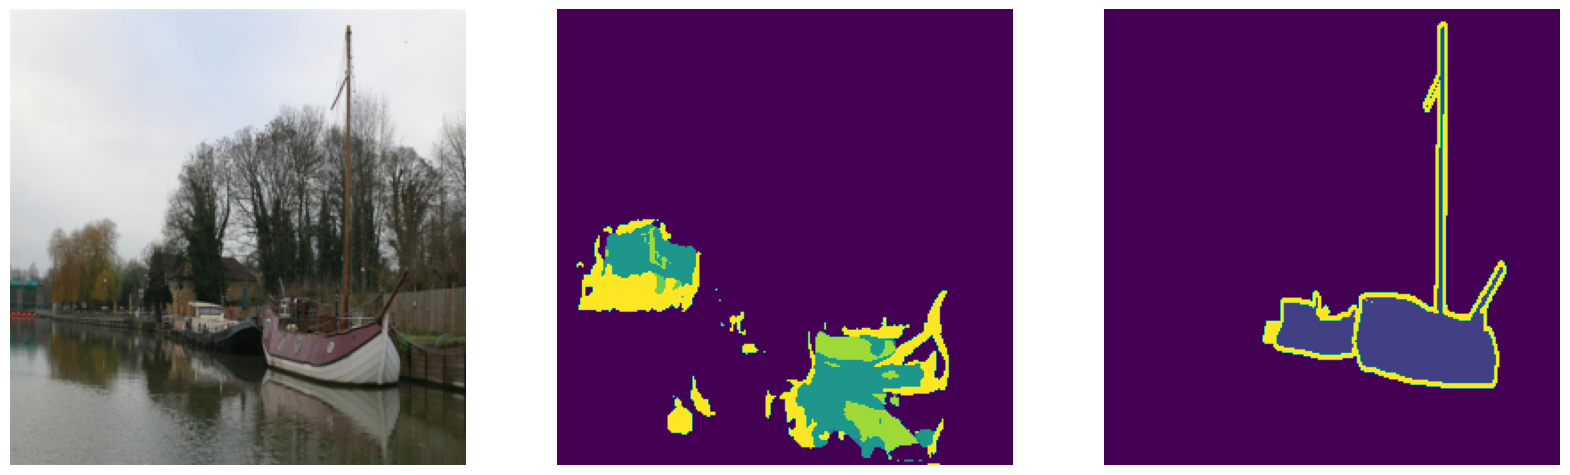

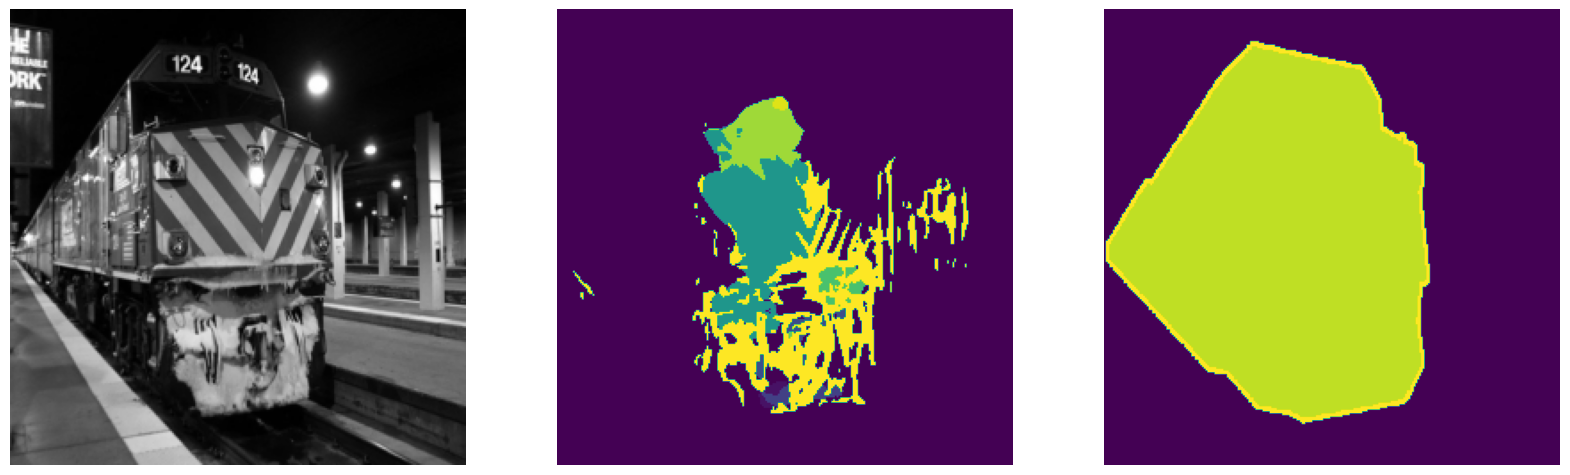

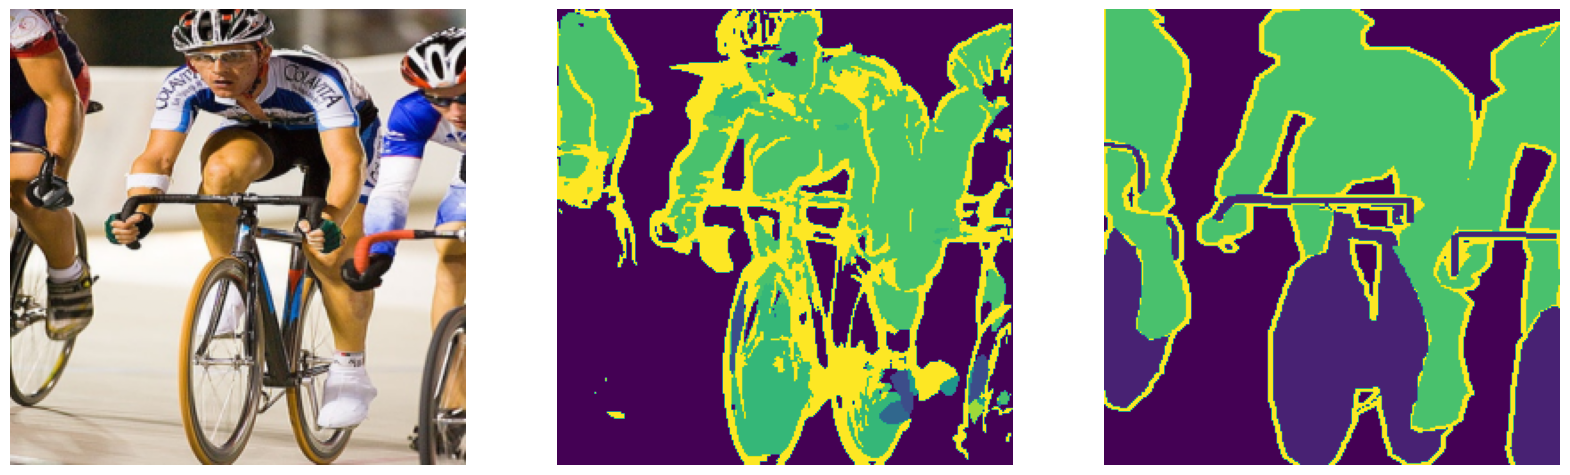

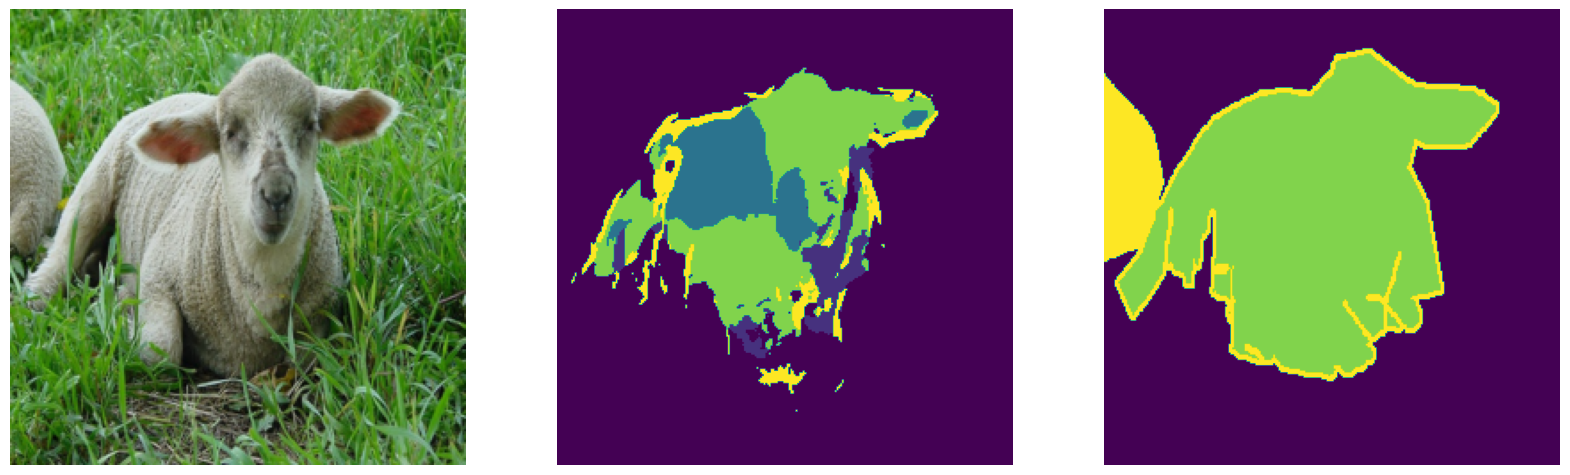

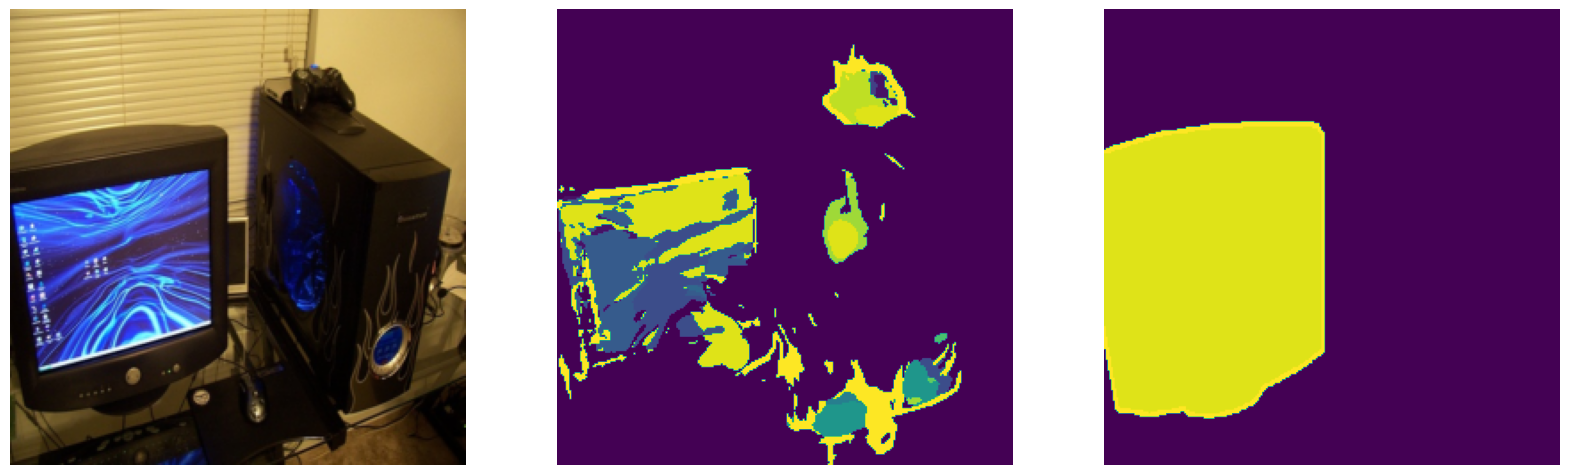

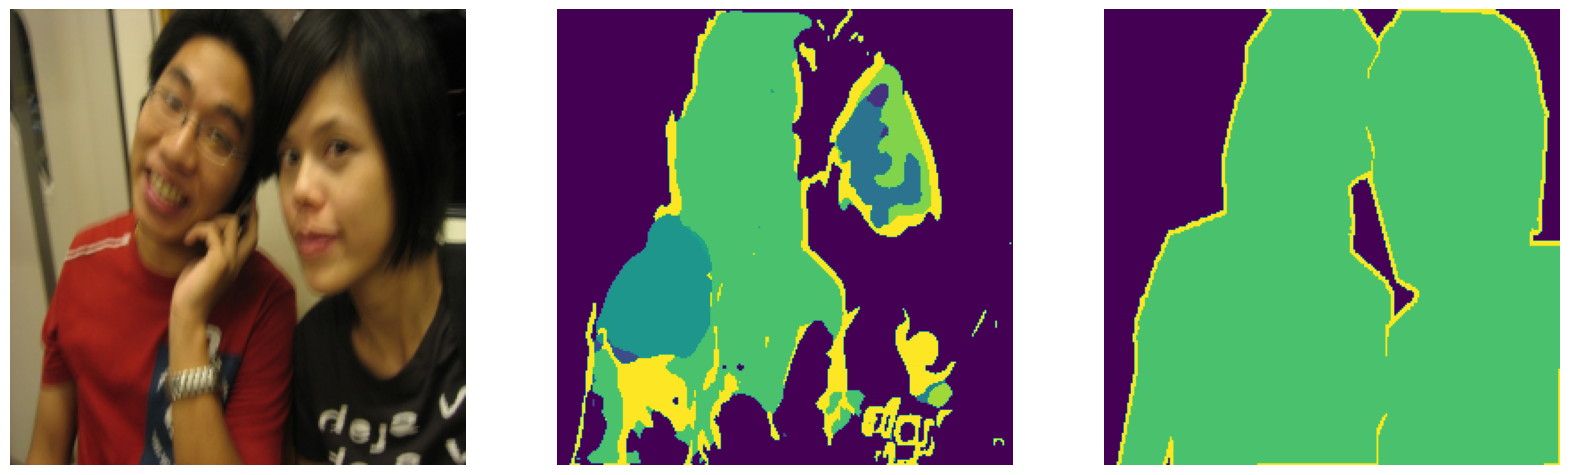

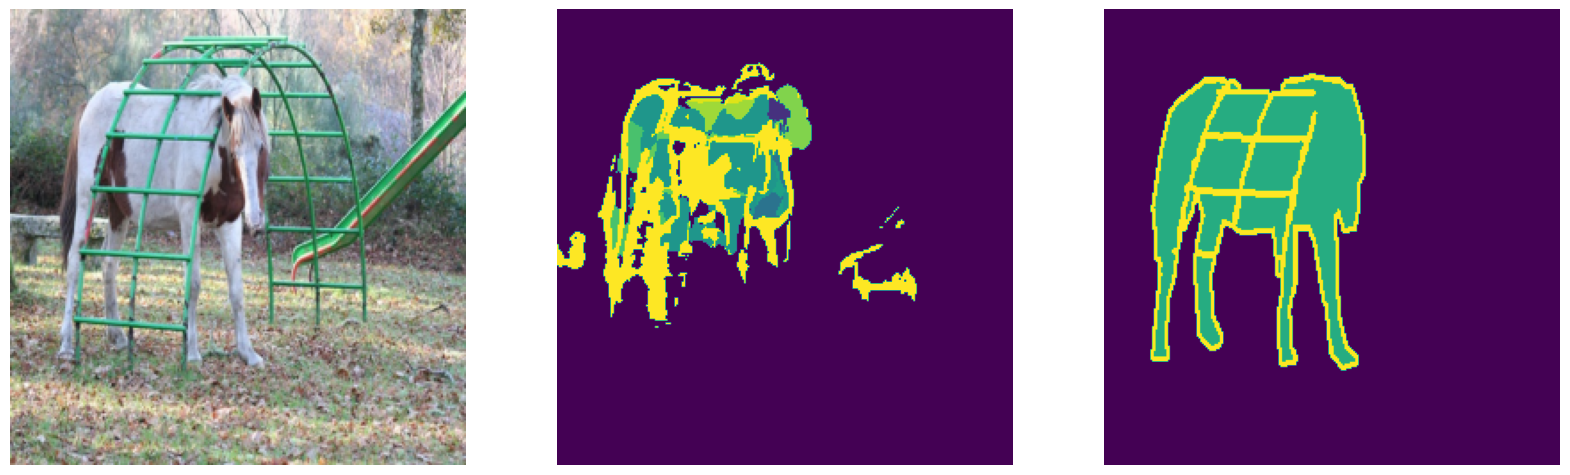

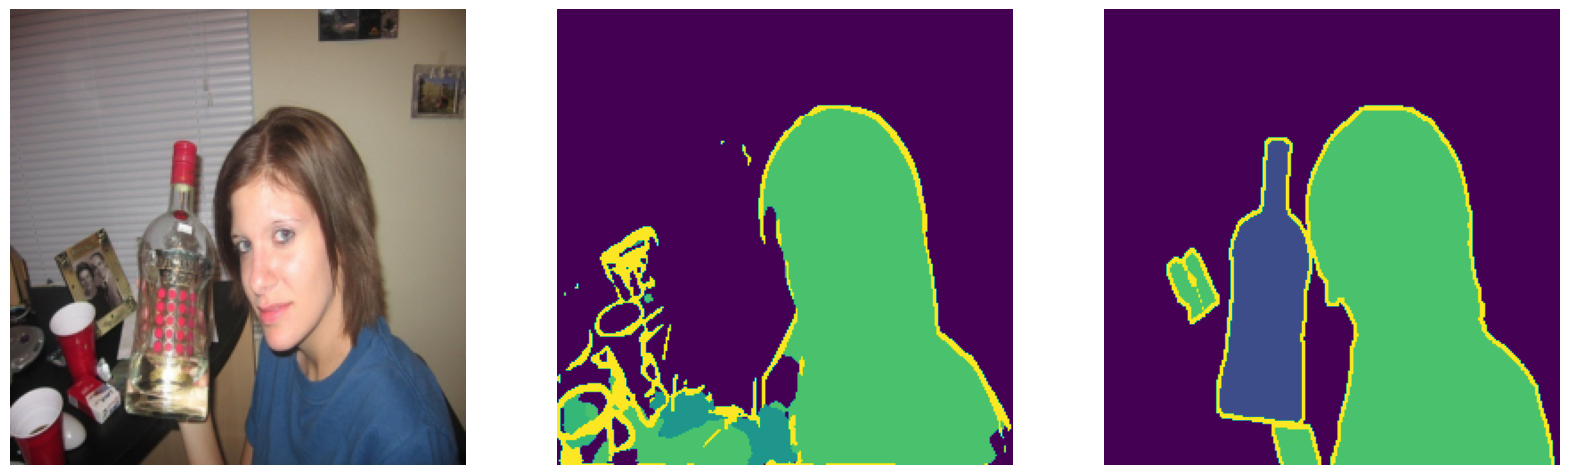

In [13]:
model.eval()

with torch.no_grad():
    for test_case_idx in range(10):
        valid_img, valid_mask = test_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)     
        # f, axarr = plt.subplots(1, total_num_class + 3, figsize = (20,15))
        f, axarr = plt.subplots(1, 3, figsize = (20,15))
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(torch.argmax(gen_mask[0], dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        axarr[2].imshow(torch.argmax(valid_mask, dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[2].axis('off')
        # for idx in range(total_num_class):
        #     axarr[idx + 2].imshow(gen_mask[0][idx].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        #     axarr[idx + 2].axis('off')
        # axarr[total_num_class+2].imshow(torch.argmax(valid_mask, dim=0).unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        # axarr[total_num_class+2].axis('off')